<a href="https://colab.research.google.com/github/MarioJorgeGoncalves/CODIGOS_LIDAR/blob/main/Interpolacao_5_10_20_50_vizinhos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [760]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [761]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [762]:
!pip install rioxarray --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [763]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as riox
import geopandas as gpd
import rasterio
from scipy.spatial import KDTree
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
from rasterio.fill import fillnodata


In [764]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


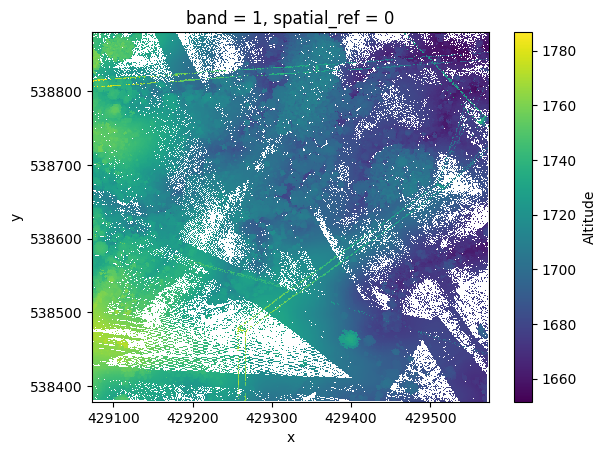

In [765]:
# LEITURA RASTER
path='/content/drive/Shareddrives/Enline_MAX/Mario/Imagens_LAS/DSM_500m_maximo.tif'
raster = riox.open_rasterio(path)
raster.plot()

In [766]:
###

In [767]:
# Array com os valores de elevação
z=raster.data # dimensão 1 x 501 x 501
z.shape
z

array([[[    nan,     nan, 1677.04, ...,     nan,     nan,     nan],
        [    nan,     nan, 1677.04, ...,     nan,     nan,     nan],
        [    nan,     nan, 1675.65, ..., 1742.14, 1740.77, 1741.01],
        ...,
        [1663.45, 1663.93, 1664.45, ..., 1744.03, 1744.94,     nan],
        [1664.21, 1664.47, 1664.35, ..., 1744.09, 1744.71,     nan],
        [    nan,     nan,     nan, ...,     nan, 1744.84,     nan]]])

In [768]:
z[0].shape # dimensão 2D 501 x 501
z[0]

array([[    nan,     nan, 1677.04, ...,     nan,     nan,     nan],
       [    nan,     nan, 1677.04, ...,     nan,     nan,     nan],
       [    nan,     nan, 1675.65, ..., 1742.14, 1740.77, 1741.01],
       ...,
       [1663.45, 1663.93, 1664.45, ..., 1744.03, 1744.94,     nan],
       [1664.21, 1664.47, 1664.35, ..., 1744.09, 1744.71,     nan],
       [    nan,     nan,     nan, ...,     nan, 1744.84,     nan]])

In [769]:
# Contagem dos valores nan dentro da raster 2D
n_nan = np.count_nonzero(np.isnan(z[0]))
n_nan # 47214 / 251001 

47214

In [770]:
z

array([[[    nan,     nan, 1677.04, ...,     nan,     nan,     nan],
        [    nan,     nan, 1677.04, ...,     nan,     nan,     nan],
        [    nan,     nan, 1675.65, ..., 1742.14, 1740.77, 1741.01],
        ...,
        [1663.45, 1663.93, 1664.45, ..., 1744.03, 1744.94,     nan],
        [1664.21, 1664.47, 1664.35, ..., 1744.09, 1744.71,     nan],
        [    nan,     nan,     nan, ...,     nan, 1744.84,     nan]]])

In [771]:
z[0,:6, :6]

array([[    nan,     nan, 1677.04, 1677.65, 1677.9 , 1677.56],
       [    nan,     nan, 1677.04, 1677.07, 1677.34, 1675.51],
       [    nan,     nan, 1675.65, 1676.44, 1676.01, 1677.16],
       [    nan,     nan, 1675.79, 1675.49, 1676.56, 1677.31],
       [    nan,     nan, 1676.  , 1675.39, 1676.46, 1676.9 ],
       [    nan,     nan, 1675.82, 1675.34, 1675.64, 1676.59]])

In [772]:
# ALTERNATIVA QUE TAMBÈM NAO DÁ VALORES CORRETOS

# def interpolate_missing_values(arr):
#     rows, cols = arr.shape
#     for i in range(rows):
#         for j in range(cols):
#             if np.isnan(arr[i, j]):
#                 # find the nearest 5 neighbors
#                 neighbors = []
#                 if i > 0:
#                     neighbors.append(arr[i-1, j])
#                 if i < rows-1:
#                     neighbors.append(arr[i+1, j])
#                 if j > 0:
#                     neighbors.append(arr[i, j-1])
#                 if j < cols-1:
#                     neighbors.append(arr[i, j+1])
#                 if i > 0 and j > 0:
#                     neighbors.append(arr[i-1, j-1])
#                 if i < rows-1 and j > 0:
#                     neighbors.append(arr[i+1, j-1])
#                 if i > 0 and j < cols-1:
#                     neighbors.append(arr[i-1, j+1])
#                 if i < rows-1 and j < cols-1:
#                     neighbors.append(arr[i+1, j+1])
                
#                 # interpolate missing value with the average of the nearest 5 neighbors
#                 arr[i, j] = np.mean([n for n in neighbors if not np.isnan(n)])
    
#     return arr

In [773]:
# Função para calcular os pixeis nan em função dos 5 pixeis com valor, mais próximos do valor faltante - NEAREST NEIGHBOR
def interpolate_missing_values(arr):
    """
    Interpolates missing values of a 2D array with the average of the nearest 5 neighbors.
    """
    rows, cols = arr.shape 
    
    # Create a copy of the array to avoid modifying the original array
    arr_copy = arr.copy() # cria uma cópia do array de 501 por 501
    
    # Find the indices of the missing values - encontra os índices dos valores nan
    missing_indices = np.where(np.isnan(arr_copy))
    
    # Iterate over each missing value - itera cada valor nan em x,y
    for i, j in zip(missing_indices[0], missing_indices[1]):
        # Find the indices of the nearest 5 neighbors with values - encontra os 5 valores mais próximos com base nas distâncias
        distances = []
        for x in range(max(0, i-1), min(rows, i+2)):
            for y in range(max(0, j-1), min(cols, j+2)):
                if not np.isnan(arr_copy[x,y]) and (x,y) != (i,j):
                    distances.append((np.sqrt((x-i)**2 + (y-j)**2), arr_copy[x,y]))
        distances.sort()
        nearest_neighbors = [value for _, value in distances[:5]] # só funciona com os 5 mais próximos!!!!!!
        
        # Calculate the average of the nearest 5 neighbors - calcula a média dos 5 valores de elevação mais próximos do pixel nan
        if nearest_neighbors:
            average = np.mean(nearest_neighbors)
            arr_copy[i,j] = average
    
    return arr_copy

In [774]:
# FUNÇÃO PARA INTERPOLAR 10 PONTOS MAIS PRÓXIMOS
# def interpolate_missing_values(arr):
#     """
#     Interpolates missing values of a 2D array with the average of the nearest 10 neighbors.
#     """
#     rows, cols = arr.shape 
    
#     # Create a copy of the array to avoid modifying the original array
#     arr_copy = arr.copy()
    
#     # Find the indices of the missing values
#     missing_indices = np.where(np.isnan(arr_copy))
    
#     # Iterate over each missing value
#     for i, j in zip(missing_indices[0], missing_indices[1]):
#         # Find the indices of the nearest 10 neighbors with values
#         distances = []
#         for x in range(max(0, i-1), min(rows, i+2)):
#             for y in range(max(0, j-1), min(cols, j+2)):
#                 if not np.isnan(arr_copy[x,y]) and (x,y) != (i,j):
#                     distances.append((np.sqrt((x-i)**2 + (y-j)**2), arr_copy[x,y]))
#         distances.sort()
#         nearest_neighbors = [value for _, value in distances[:10]] # using the 10 nearest neighbors
        
#         # Calculate the average of the nearest 10 neighbors
#         if nearest_neighbors:
#             average = np.mean(nearest_neighbors)
#             arr_copy[i,j] = average
    
#     return arr_copy

In [775]:
# FUNÇÃO PARA INTERPOLAR 20 PONTOS MAIS PRÓXIMOS
# def interpolate_missing_values(arr):
#     """
#     Interpolates missing values of a 2D array with the average of the nearest 20 neighbors.
#     """
#     rows, cols = arr.shape
    
#     # Create a copy of the array to avoid modifying the original array
#     arr_copy = arr.copy()
    
#     # Find the indices of the missing values
#     missing_indices = np.where(np.isnan(arr_copy))
    
#     # Iterate over each missing value
#     for i, j in zip(missing_indices[0], missing_indices[1]):
#         # Find the indices of the nearest 20 neighbors with values
#         distances = []
#         for x in range(max(0, i-5), min(rows, i+6)):
#             for y in range(max(0, j-5), min(cols, j+6)):
#                 if not np.isnan(arr_copy[x,y]) and (x,y) != (i,j):
#                     distances.append((np.sqrt((x-i)**2 + (y-j)**2), arr_copy[x,y]))
#         distances.sort()
#         nearest_neighbors = [value for _, value in distances[:20]]
        
#         # Calculate the average of the nearest 20 neighbors
#         if nearest_neighbors:
#             average = np.mean(nearest_neighbors)
#             arr_copy[i,j] = average
    
#     return arr_copy

In [776]:
# FUNÇÃO PARA INTERPOLAR 50 PONTOS MAIS PRÓXIMOS
# def interpolate_missing_values(arr):
#     """
#     Interpolates missing values of a 2D array with the average of the nearest 50 neighbors.
#     """
#     rows, cols = arr.shape 
    
#     # Create a copy of the array to avoid modifying the original array
#     arr_copy = arr.copy()
    
#     # Find the indices of the missing values
#     missing_indices = np.where(np.isnan(arr_copy))
    
#     # Iterate over each missing value
#     for i, j in zip(missing_indices[0], missing_indices[1]):
#         # Find the indices of the nearest 50 neighbors with values
#         distances = []
#         for x in range(max(0, i-5), min(rows, i+6)):
#             for y in range(max(0, j-5), min(cols, j+6)):
#                 if not np.isnan(arr_copy[x,y]) and (x,y) != (i,j):
#                     distances.append((np.sqrt((x-i)**2 + (y-j)**2), arr_copy[x,y]))
#         distances.sort()
#         nearest_neighbors = [value for _, value in distances[:50]] # using the 50 nearest neighbors
        
#         # Calculate the average of the nearest 50 neighbors
#         if nearest_neighbors:
#             average = np.mean(nearest_neighbors)
#             arr_copy[i,j] = average
    
#     return arr_copy

In [777]:
z_interpolado=interpolate_missing_values(z[0])
z_interpolado

array([[          nan, 1677.04      , 1677.04      , ..., 1731.49377188,
        1731.49377188, 1731.49377188],
       [1677.04      , 1676.762     , 1677.04      , ..., 1734.02847868,
        1733.85595887, 1735.72470053],
       [1676.901     , 1676.4286    , 1675.65      , ..., 1742.14      ,
        1740.77      , 1741.01      ],
       ...,
       [1663.45      , 1663.93      , 1664.45      , ..., 1744.03      ,
        1744.94      , 1744.86004825],
       [1664.21      , 1664.47      , 1664.35      , ..., 1744.09      ,
        1744.71      , 1744.83751206],
       [1664.34      , 1664.3425    , 1664.4330634 , ..., 1744.2528    ,
        1744.84      , 1744.79583735]])

In [778]:
n_nan = np.count_nonzero(np.isnan(z_interpolado))
n_nan

1

In [779]:
z_interpolado[:6, :6] # Verificar os nan das primeiras 6 linhas, primeiras 6 colunas

array([[         nan, 1677.04     , 1677.04     , 1677.65     ,
        1677.9      , 1677.56     ],
       [1677.04     , 1676.762    , 1677.04     , 1677.07     ,
        1677.34     , 1675.51     ],
       [1676.901    , 1676.4286   , 1675.65     , 1676.44     ,
        1676.01     , 1677.16     ],
       [1676.6648   , 1676.10668  , 1675.79     , 1675.49     ,
        1676.56     , 1677.31     ],
       [1676.38574  , 1676.020484 , 1676.       , 1675.39     ,
        1676.46     , 1676.9      ],
       [1676.203112 , 1676.0858672, 1675.82     , 1675.34     ,
        1675.64     , 1676.59     ]])

In [780]:
tif_file = '/content/drive/Shareddrives/Enline_MAX/Mario/Imagens_LAS/DSM_500m_maximo.tif'
with rasterio.open(tif_file) as src:
    profile = src.profile
    arr = src.read(1)
    arr_filled = fillnodata(arr, mask=src.read_masks(1), max_search_distance=10, smoothing_iterations=0)

arr_filled

array([[1677.04003906, 1677.04003906, 1677.04003906, ..., 1741.49316406,
        1740.88330078, 1741.01000977],
       [1676.38378906, 1676.4642334 , 1677.04003906, ..., 1741.57250977,
        1740.86938477, 1741.01000977],
       [1675.71618652, 1675.70800781, 1675.65002441, ..., 1742.14001465,
        1740.77001953, 1741.01000977],
       ...,
       [1663.44995117, 1663.93005371, 1664.44995117, ..., 1744.0300293 ,
        1744.93994141, 1744.84472656],
       [1664.20996094, 1664.4699707 , 1664.34997559, ..., 1744.08996582,
        1744.70996094, 1744.76379395],
       [1664.31762695, 1664.42028809, 1664.64660645, ..., 1744.46496582,
        1744.83996582, 1744.83996582]])

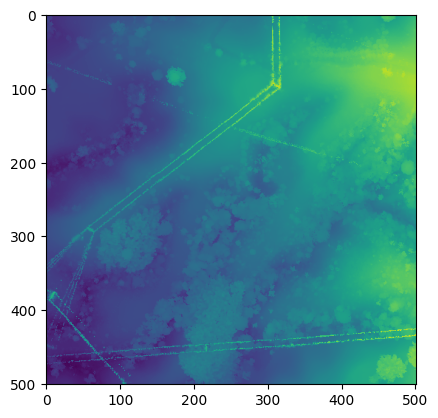

In [781]:
plt.imshow(arr_filled)

In [782]:
newtif_file = '/content/drive/Shareddrives/Enline_MAX/Mario/Imagens_LAS/DSM_interpolada_5pixeis.tif'
with rasterio.open(newtif_file, 'w', **profile) as dest:
    dest.write_band(1, arr_filled)

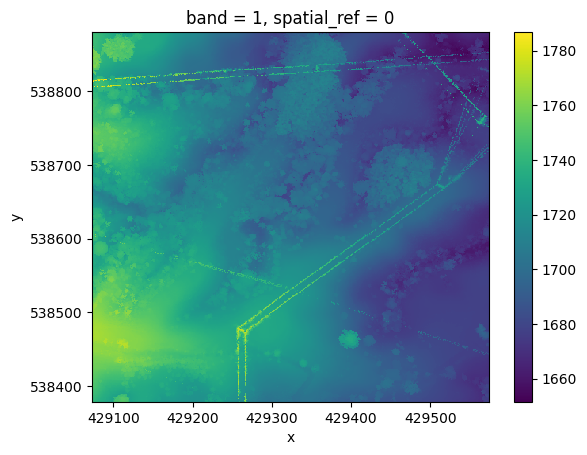

In [783]:
path='/content/drive/Shareddrives/Enline_MAX/Mario/Imagens_LAS/DSM_interpolada_5pixeis.tif'
raster = riox.open_rasterio(path)
raster.plot()